 # Tutorial: Positional Encoders in Transformers / LLMs



 This notebook demonstrates different types of positional encoders and their effect on attention mechanisms.

 We will explore:

 - No positional encoding

 - Simple linear positional encoding

 - Learned positional encoding

 - ALiBi positional bias

 - RoPE (Rotary Positional Embeddings)

 - Attention values for a key token pair

 ## 1️⃣ Setup: Tokens and embeddings

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Tokens
tokens = ["Rajendra", "Chola", "is", "a", "son", "of", "Rajaraja"]
seq_len = len(tokens)
embedding_dim = 4

# Base embeddings (toy example)
embeddings = np.array([
    [0.1, 0.2, 0.1, 0.0],
    [0.2, 0.3, 0.0, 0.1],
    [0.0, 0.1, 0.2, 0.1],
    [0.0, 0.0, 0.1, 0.2],
    [0.1, 0.0, 0.2, 0.0],
    [0.0, 0.1, 0.0, 0.1],
    [0.3, 0.1, 0.2, 0.3]
])

# Softmax helper
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)


 ## 2️⃣ Positional Encoders

In [10]:
# Simple linear positional encoding
pos_enc_linear = np.array([i*0.05 for i in range(seq_len)]).reshape(-1,1)
embeddings_linear = embeddings + pos_enc_linear

# Learned positional embeddings
np.random.seed(0)
pos_enc_learned = np.random.rand(seq_len, embedding_dim) * 0.1
embeddings_learned = embeddings + pos_enc_learned

# ALiBi positional bias
def compute_alibi(seq_len, slope=0.1):
    return -slope * (np.arange(seq_len).reshape(1,-1) - np.arange(seq_len).reshape(-1,1))

alibi_bias = compute_alibi(seq_len)

# RoPE helper functions
def rotate_half(x):
    x1 = x[..., ::2]
    x2 = x[..., 1::2]
    return np.concatenate([-x2, x1], axis=-1)

def rope(x, theta):
    x_rot = x * np.cos(theta) + rotate_half(x) * np.sin(theta)
    return x_rot


 ## 3️⃣ Attention Scores Computation

In [11]:
# Base attention scores (no positional encoding)
att_base = softmax(embeddings @ embeddings.T)

# Linear PE attention
att_linear = softmax(embeddings_linear @ embeddings_linear.T)

# Learned PE attention
att_learned = softmax(embeddings_learned @ embeddings_learned.T)

# ALiBi attention
att_alibi = softmax(embeddings @ embeddings.T + alibi_bias)

# RoPE demo (for toy embeddings)
theta = np.linspace(0, np.pi/2, embedding_dim)
emb_rope = rope(embeddings[:seq_len], theta)
att_rope = softmax(emb_rope @ emb_rope.T)


 ## 4️⃣ Visualizing Attention Heatmaps

C:\Users\arung\AppData\Local\Temp\ipykernel_16336\1997872877.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


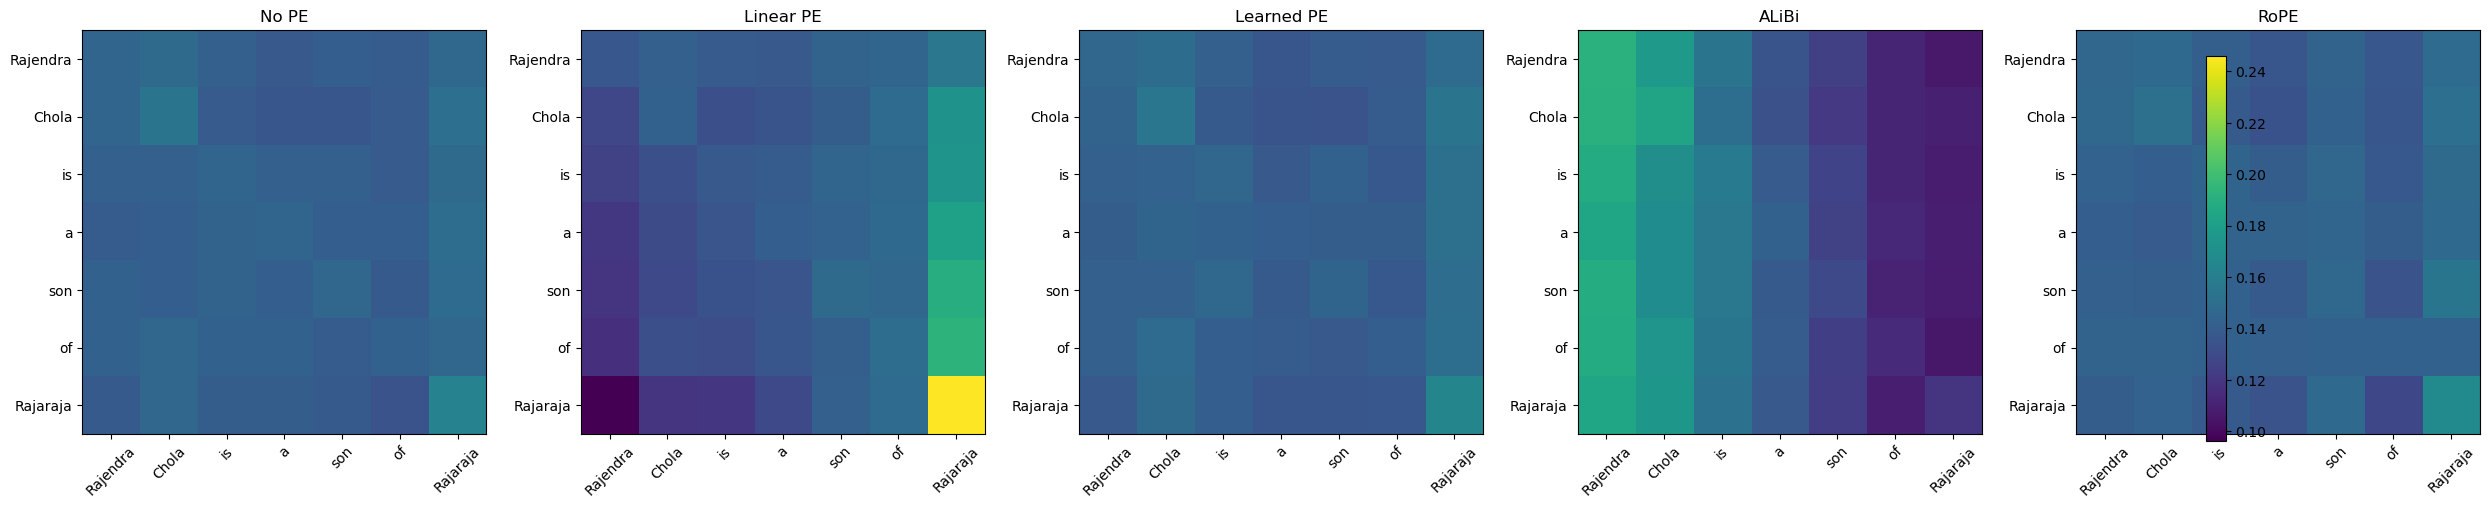

In [12]:
vmin = min(att_base.min(), att_linear.min(), att_learned.min(), att_alibi.min(), att_rope.min())
vmax = max(att_base.max(), att_linear.max(), att_learned.max(), att_alibi.max(), att_rope.max())

fig, axs = plt.subplots(1,5,figsize=(25,5))

heatmaps = [att_base, att_linear, att_learned, att_alibi, att_rope]
titles = ["No PE", "Linear PE", "Learned PE", "ALiBi", "RoPE"]

for ax, hm, title in zip(axs, heatmaps, titles):
    im = ax.imshow(hm, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45)
    ax.set_yticklabels(tokens)

fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()


 ## 5️⃣ Attention Values Between Specific Tokens



 Extract the attention scores from **Rajendra → Rajaraja** and **Rajaraja → Rajendra** for each positional encoder.

In [13]:
# Indices
idx_rajendra = tokens.index("Rajendra")
idx_rajaraja = tokens.index("Rajaraja")

# Function to extract attention values
def attention_values(att_matrix):
    return (att_matrix[idx_rajendra, idx_rajaraja],
            att_matrix[idx_rajaraja, idx_rajendra])

# Attention values
att_base_vals = attention_values(att_base)
att_linear_vals = attention_values(att_linear)
att_learned_vals = attention_values(att_learned)
att_alibi_vals = attention_values(att_alibi)
att_rope_vals = attention_values(att_rope)

# Print results
print("=== Attention values (Rajendra ↔ Rajaraja) ===")
print(f"No PE:               Rajendra→Rajaraja: {att_base_vals[0]:.4f}, Rajaraja→Rajendra: {att_base_vals[1]:.4f}")
print(f"Linear PE:           Rajendra→Rajaraja: {att_linear_vals[0]:.4f}, Rajaraja→Rajendra: {att_linear_vals[1]:.4f}")
print(f"Learned PE:          Rajendra→Rajaraja: {att_learned_vals[0]:.4f}, Rajaraja→Rajendra: {att_learned_vals[1]:.4f}")
print(f"ALiBi:               Rajendra→Rajaraja: {att_alibi_vals[0]:.4f}, Rajaraja→Rajendra: {att_alibi_vals[1]:.4f}")
print(f"RoPE:                Rajendra→Rajaraja: {att_rope_vals[0]:.4f}, Rajaraja→Rajendra: {att_rope_vals[1]:.4f}")


=== Attention values (Rajendra ↔ Rajaraja) ===
No PE:               Rajendra→Rajaraja: 0.1465, Rajaraja→Rajendra: 0.1386
Linear PE:           Rajendra→Rajaraja: 0.1555, Rajaraja→Rajendra: 0.0961
Learned PE:          Rajendra→Rajaraja: 0.1485, Rajaraja→Rajendra: 0.1377
ALiBi:               Rajendra→Rajaraja: 0.1062, Rajaraja→Rajendra: 0.1842
RoPE:                Rajendra→Rajaraja: 0.1486, Rajaraja→Rajendra: 0.1405


 ## 6️⃣ Positional Encoder Formulas



 ### 1. Absolute Sinusoidal Positional Encoding


$ PE_{p, 2i} = \sin \left( \frac{p}{10000^{2i/d}} \right), \quad
 PE_{p, 2i+1} = \cos \left( \frac{p}{10000^{2i/d}} \right) $

 - Fixed for each position, no learned parameters.

 - Can extrapolate to unseen sequence lengths.



 ### 2. Learned Absolute Positional Encoding


$
 PE_p \in \mathbb{R}^d, \quad \text{learned via backpropagation}
$
 - Flexible, adapts to training data.

 - Does not extrapolate well beyond trained length.



 ### 3. Rotary Positional Embeddings (RoPE)



 For each embedding pair $\([x_{2i}, x_{2i+1}]\)$:



 
$
 [x'_{2i}, x'_{2i+1}] =

 \begin{bmatrix} \cos \theta_p & -\sin \theta_p \\ \sin \theta_p & \cos \theta_p \end{bmatrix} [x_{2i}, x_{2i+1}]
$
 
 - Rotates the embedding pair depending on position \(p\).

 - Encodes relative positions naturally.



 ### 4. ALiBi (Attention with Linear Bias)



 Add a linear bias to attention score based on distance between tokens:



 
 $\text{Attention}(Q,K) = \text{softmax}(QK^T + \text{bias}(i-j))$
 where $\( \text{bias}(i-j) = -\text{slope} \cdot (i-j) \)$.

 - Closer tokens are favored, works well for long sequences.

 ## 7️⃣ Modern LLMs and positional encoders

 | Model / Company | Positional Encoder Type | Max Context Length | Notes |

 |-----------------|-----------------------|-----------------|------|

 | ChatGPT (GPT-4) | Learned absolute embeddings | 8k–32k | Extended context in newer variants |

 | Gemini (Google DeepMind) | RoPE | 8k+ | Uses scaled RoPE for long context |

 | Claude (Anthropic) | RoPE or hybrid (ALiBi+RoPE) | 100k | Long-context focused |

 | LLaMA (Meta) | RoPE | 4k–8k (std) | α-scaling for extended context |

 | DeepSeek | RoPE or ALiBi | 16k–32k | Long-document processing |

 ✅ **Summary**



 - Positional encoders are **critical for Transformers to know token order**.

 - Different methods (linear, learned, ALiBi, RoPE) **alter attention differently**.

 - The attention scores for `Rajendra ↔ Rajaraja` illustrate how token order is represented.

 - Modern LLMs mostly use **RoPE or ALiBi variants** for long-context handling.